GLCM 특징을 이용하여 SVM으로 분류해보기

In [2]:
from skimage.feature import greycomatrix, greycoprops
from sklearn.svm import LinearSVC
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

def image_read(folder, name, fx=0.25, fy=0.25, gray=False):
    image = cv2.imread(folder + name)
    image = cv2.resize(image, None, fx=fx, fy=fy, interpolation=cv2.INTER_AREA)
    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def extract_glcm_feature(image):
    glcm = greycomatrix(image, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    list_features = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]
    feature = [greycoprops(glcm, f)[0, 0] for f in list_features]
    return feature

def extract_glcm_feature_RGB(image):
    feature = []
    for i in range(3):  # BGR순으로 feature를 뽑는다.
        feature += extract_glcm_feature(image[:, :, i])
    return feature

def get_class_color_legend_img(class_names, class_colors):
    # label 색상에 대한 범례를 만들어주는 함수이다.
    legend = np.zeros(((len(class_names) * 25) + 25, 300, 3), dtype="uint8")

    for (i, (name, color)) in enumerate(zip(class_names, class_colors)):
        # draw the class name + color on the legend
        color = [int(c) for c in color]
        cv2.putText(legend, name, (5, (i * 25) + 17),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25),
                      tuple((color)), -1)

    return legend

Grayscale로 test

grass
road
rocks


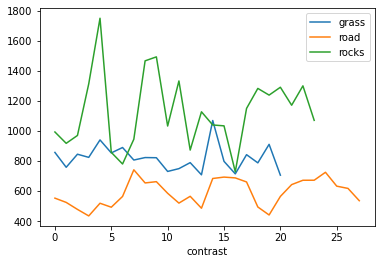

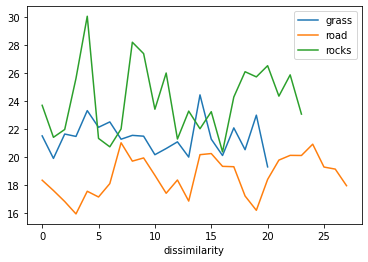

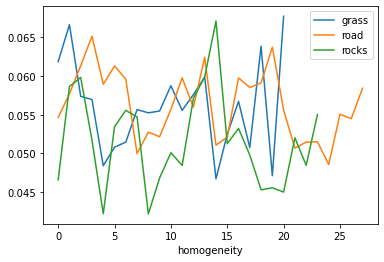

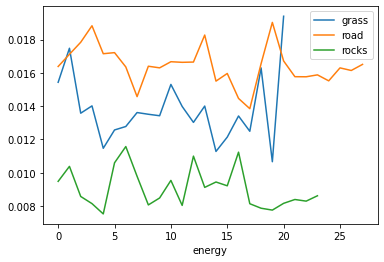

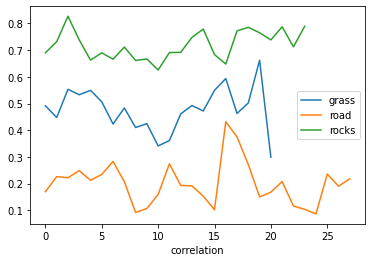

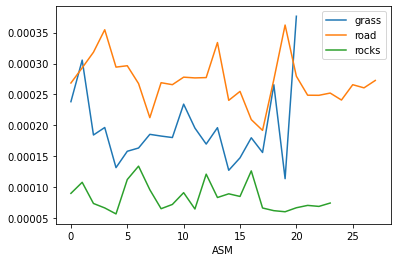

grass.jpg ['grass']


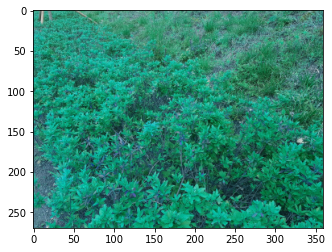

road.jpg ['road']


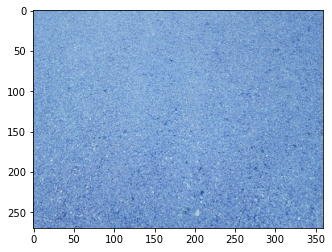

rocks.jpg ['rocks']


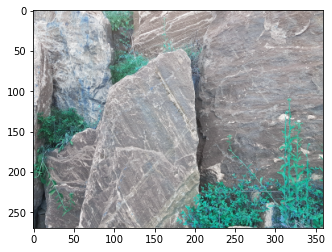

In [3]:
training_folder = "./images/training/" # training image 경로
kind_of_label = os.listdir(training_folder)# label종류
features = [] # glcm feature가 저장될 리스트
labels = [] # 해당 image feature에 대응하는 label 리스트

for label in kind_of_label:#label별로 특징을 뽑아낸다.
    print(label)    
    image_folder = training_folder + label + "/" # 학습할 image가 있는 경로
    image_names = os.listdir(image_folder)#image 목록
    
    for image_name in image_names:
        
        image = image_read(image_folder, image_name)# 이미지 읽어들이기
        
        feature = extract_glcm_feature_RGB(image)# glcm feature를 뽑는다.
            
        labels.append(label)# 해당 image의 label을 저장한다.
        features.append(feature)# 해당 image의 feature를 저장한다.
        
#         cv2.imshow("sample",image)# image출력
#         cv2.waitKey(1)
# cv2.destroyAllWindows()

glcm_features = np.array(features)
labels = np.array(labels)

list_features = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]#feature 종류
for i in range(len(list_features)):
    for label in kind_of_label:
        plt.plot(glcm_features[labels == label][:,i], label=label)
    plt.legend()
    plt.xlabel(list_features[i])
    plt.show()
    
#model 학습
model = LinearSVC(C=1, random_state=42, max_iter = 100000000)
model.fit(glcm_features, labels)

testing_images_path = "./images/testing/"#test이미지가 저장되어 있는 곳

for image_name in os.listdir(testing_images_path):
    
    image = image_read(testing_images_path, image_name)
    feature = []
    for i in range(3):#RGB별로 feature뽑기
        feature += extract_glcm_feature(image[:,:,i])
    
    prediction = model.predict(np.array(feature).reshape([1,-1]))# 분류하기
    
    print(image_name, prediction)
    
    plt.imshow(image)
    plt.show()

(972, 10, 10, 3)
27 36
12.649685621261597


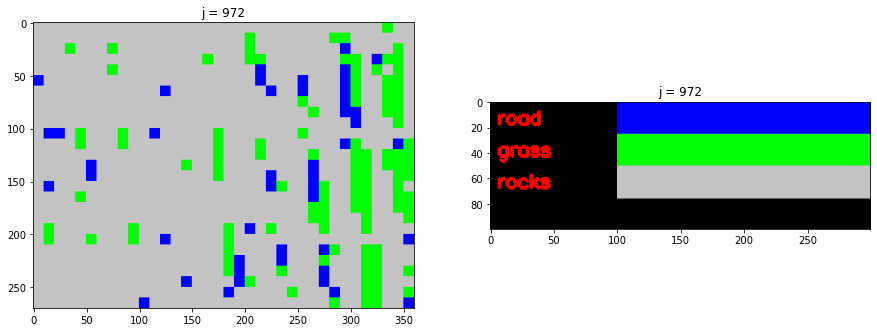

In [4]:
import time
# image = image_read("./images/temp/", "road_scene3.jpg")
# cv2.imshow("temp", image)

PATCH_SIZE = 10 #이미지를 블록으로 나눔
height, width, channel = image.shape
# patches = image.reshape(image.shape[0]//PATCH_SIZE, PATCH_SIZE, image.shape[1]//PATCH_SIZE, PATCH_SIZE).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE)
patches = image.reshape(height//PATCH_SIZE, PATCH_SIZE, width//PATCH_SIZE, PATCH_SIZE, channel).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE, channel)


mask = np.zeros((height//PATCH_SIZE, width//PATCH_SIZE, channel), np.uint8)
label_color = {
    "road" : np.array([0,0,255]),
    "grass" : np.array([0,255,0]),
    "rocks" : np.array([195,195,195])
}
h = height//PATCH_SIZE
w = width//PATCH_SIZE

print(patches.shape)
print(h, w)

start = time.time()
for i in range(patches.shape[0]):
    feature = extract_glcm_feature_RGB(patches[i])
    prediction = model.predict(np.array(feature).reshape([1, -1]))  # 분류하기
#     print(prediction)
    mask[i%h][i//h] = label_color[prediction[0]]
#     cv2.imshow("patch",patches[i])
#     cv2.waitKey(2)

end = time.time()
print(end - start)
mask = cv2.resize(mask, None, fx=PATCH_SIZE, fy=PATCH_SIZE, interpolation=cv2.INTER_AREA)
# cv2.imshow("mask", mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

legend_img = get_class_color_legend_img(label_color.keys(), label_color.values())
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=False, sharey=False)

ax[0].imshow(mask)
ax[0].set_title("j = {}".format(i+1))

ax[1].imshow(legend_img)
ax[1].set_title("j = {}".format(i+1))

plt.show()

Train image를 쪼개지 않고 통째로 사용하기

In [5]:
training_folder = "./images/training/" # training image 경로
kind_of_label = os.listdir(training_folder)# label종류
features = [] # glcm feature가 저장될 리스트
labels = [] # 해당 image feature에 대응하는 label 리스트

for label in kind_of_label:#label별로 특징을 뽑아낸다.
    print(label)    
    image_folder = training_folder + label + "/" # 학습할 image가 있는 경로
    image_names = os.listdir(image_folder)#image 목록
    
    for image_name in image_names:
        
        image = image_read(image_folder, image_name)# 이미지 읽어들이기
        
        feature = extract_glcm_feature_RGB(image)# glcm feature를 뽑는다.
            
        labels.append(label)# 해당 image의 label을 저장한다.
        features.append(feature)# 해당 image의 feature를 저장한다.
        
        cv2.imshow("sample",image)# image출력
        cv2.waitKey(1)
cv2.destroyAllWindows()

glcm_features = np.array(features)
labels = np.array(labels)

print(glcm_features.shape)

grass
road
rocks
(73, 18)


In [6]:
kind_of_label # 학습할 이미지 종류

['grass', 'road', 'rocks']

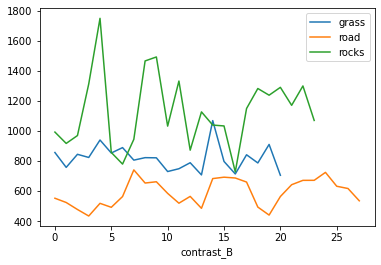

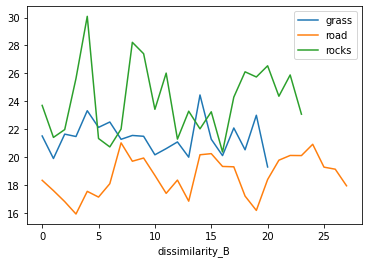

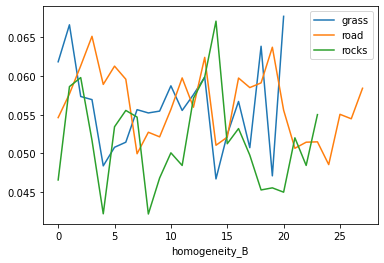

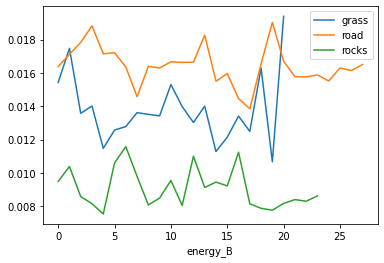

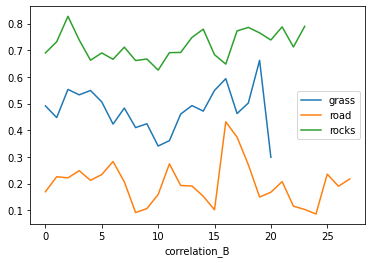

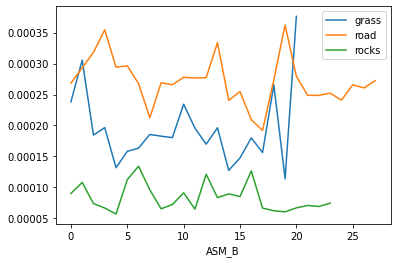

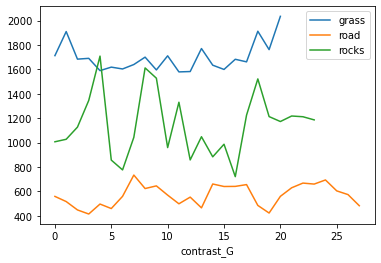

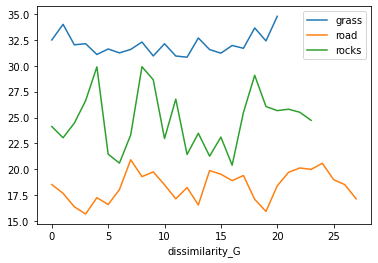

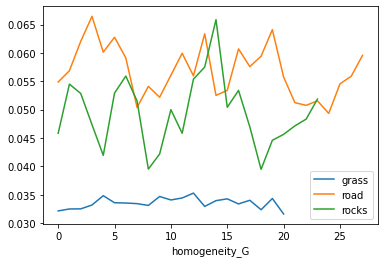

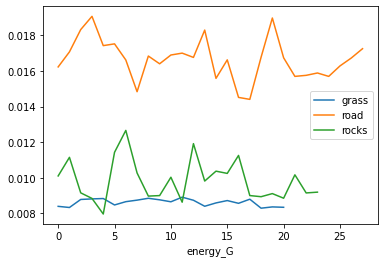

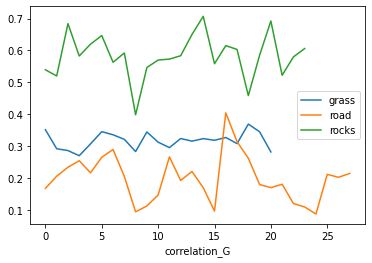

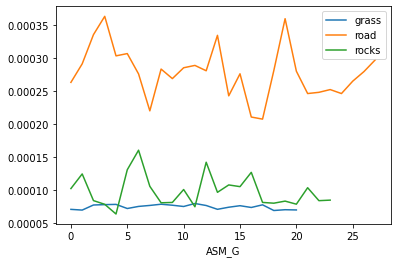

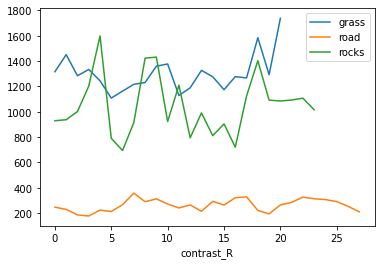

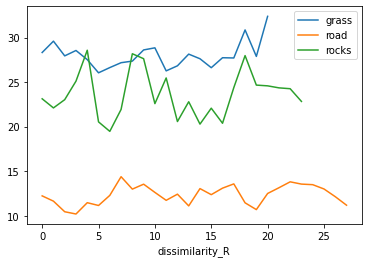

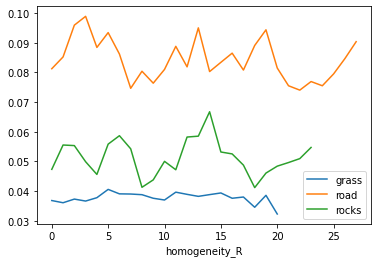

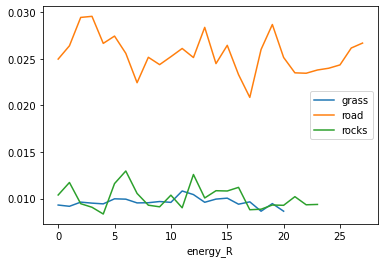

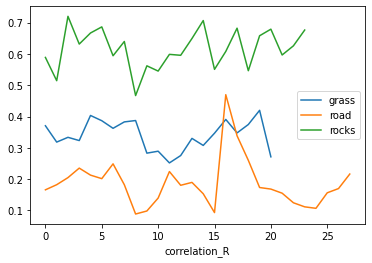

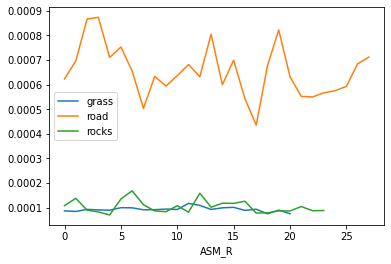

In [7]:
list_features = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]#feature 종류
rgb = ["B","G","R"]
for n, c in enumerate(rgb):#RGB별로 비교해본다.
    for i in range(len(list_features)):
        for label in kind_of_label:
            plt.plot(glcm_features[labels == label][:,6*n+i], label=label)
        plt.legend()
        plt.xlabel(list_features[i]+"_"+c)
        plt.show()

In [8]:
#model 학습
model = LinearSVC(C=1, random_state=42, max_iter = 100000000)
model.fit(glcm_features, labels)

LinearSVC(C=1, max_iter=100000000, random_state=42)

grass.jpg ['grass']


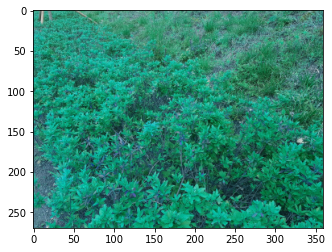

road.jpg ['road']


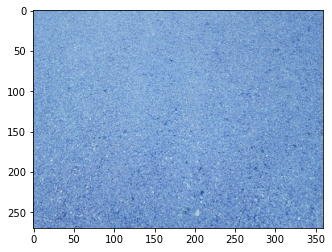

rocks.jpg ['rocks']


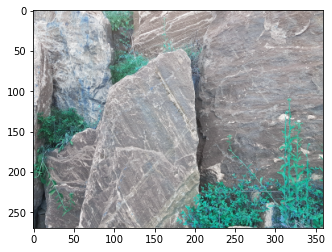

In [9]:
testing_images_path = "./images/testing/"#test이미지가 저장되어 있는 곳

for image_name in os.listdir(testing_images_path):
    
    image = image_read(testing_images_path, image_name)
    feature = []
    for i in range(3):#RGB별로 feature뽑기
        feature += extract_glcm_feature(image[:,:,i])
    
    prediction = model.predict(np.array(feature).reshape([1,-1]))# 분류하기
    
    print(image_name, prediction)
    
    plt.imshow(image)
    plt.show()

In [10]:
with open('linearSVC.pickle', 'wb') as f:# model 저장
    pickle.dump(model, f)

In [11]:
# with open('linearSVC.pickle', 'rb') as f:
#     model = pickle.load(f)

(972, 10, 10, 3)
27 36
8.244999170303345


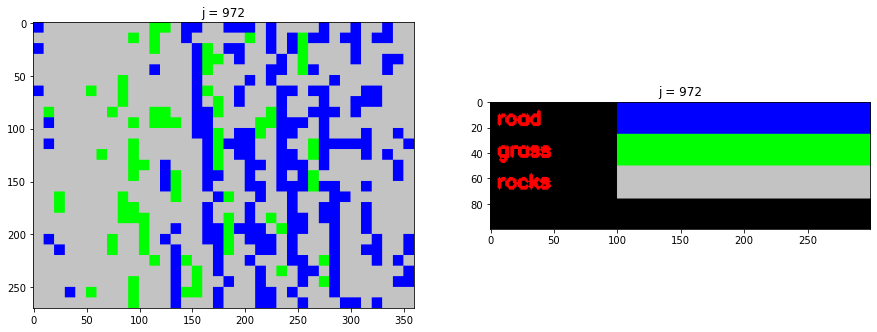

In [12]:
import time
image = image_read("./images/temp/", "road_scene3.jpg")
# cv2.imshow("temp", image)

PATCH_SIZE = 10 #이미지를 블록으로 나눔
height, width, channel = image.shape
# patches = image.reshape(image.shape[0]//PATCH_SIZE, PATCH_SIZE, image.shape[1]//PATCH_SIZE, PATCH_SIZE).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE)
patches = image.reshape(height//PATCH_SIZE, PATCH_SIZE, width//PATCH_SIZE, PATCH_SIZE, channel).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE, channel)


mask = np.zeros((height//PATCH_SIZE, width//PATCH_SIZE, channel), np.uint8)
label_color = {
    "road" : np.array([0,0,255]),
    "grass" : np.array([0,255,0]),
    "rocks" : np.array([195,195,195])
}
h = height//PATCH_SIZE
w = width//PATCH_SIZE

print(patches.shape)
print(h, w)

start = time.time()
for i in range(patches.shape[0]):
    feature = extract_glcm_feature_RGB(patches[i])
    prediction = model.predict(np.array(feature).reshape([1, -1]))  # 분류하기
#     print(prediction)
    mask[i%h][i//h] = label_color[prediction[0]]
#     cv2.imshow("patch",patches[i])
#     cv2.waitKey(2)

end = time.time()
print("extracting time : ",end - start)
mask = cv2.resize(mask, None, fx=PATCH_SIZE, fy=PATCH_SIZE, interpolation=cv2.INTER_AREA)
# cv2.imshow("mask", mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

legend_img = get_class_color_legend_img(label_color.keys(), label_color.values())
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=False, sharey=False)

ax[0].imshow(mask)
ax[0].set_title("j = {}".format(i+1))

ax[1].imshow(legend_img)
ax[1].set_title("j = {}".format(i+1))

plt.show()

Train 이미지를 여래개의 patch로 쪼개서 glcm을 추출하여 학습시켜 보기

In [13]:
training_folder = "./images/training/" # training image 경로
kind_of_label = os.listdir(training_folder)# label종류
features = [] # glcm feature가 저장될 리스트
labels = [] # 해당 image feature에 대응하는 label 리스트

In [14]:
image_folder = training_folder + kind_of_label[1] + "/" # image가 있는 경로
image_names = os.listdir(image_folder)#image 목록

In [15]:
image = image_read(image_folder, image_names[0])
# cv2.imshow("image", image)
road_scene = image_read("./images/temp/","road_scene.jpg")
# cv2.imshow("road_scene", road_scene)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# plt.imshow(image)
# plt.show()
# plt.imshow(road_scene)
# plt.show()

In [17]:
PATCH_SIZE = 10 #이미지를 블록으로 나눔

for label in kind_of_label:#label별로 특징을 뽑아낸다.
    print(label)    
    image_folder = training_folder + label + "/" # 학습에 사용될 image가 있는 경로
    image_names = os.listdir(image_folder)#image 목록
    
    for image_name in image_names:
        
        image = image_read(image_folder, image_name)# 이미지 읽어들이기
        image = cv2.GaussianBlur(image, (15,15), 5)
        
#         cv2.imshow("sample",image)# image출력
#         cv2.waitKey(1)
        
        height, width, channel = image.shape
        patches = image.reshape(height//PATCH_SIZE, PATCH_SIZE, width//PATCH_SIZE, PATCH_SIZE, channel).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE, channel)
        
        for i in range(patches.shape[0]):
            feature = extract_glcm_feature_RGB(image)
            labels.append(label)
            features.append(feature)
#             cv2.imshow("patch", patches[i])
#             cv2.waitKey(1)
        
# cv2.destroyAllWindows()

glcm_features = np.array(features)
labels = np.array(labels)

print(glcm_features.shape)

grass
road
rocks
(72020, 18)


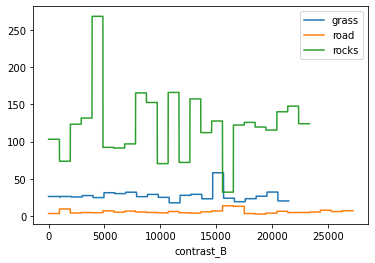

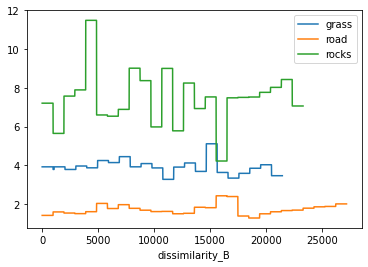

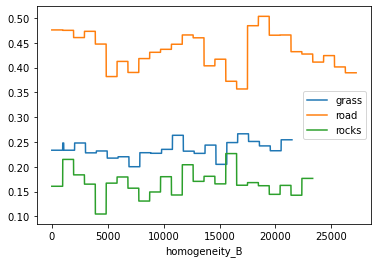

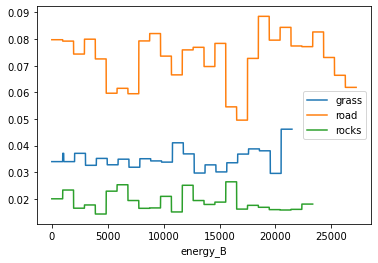

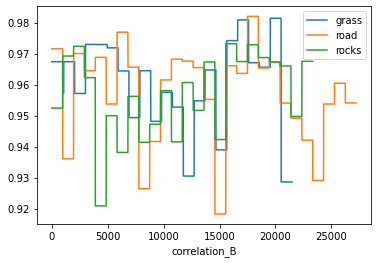

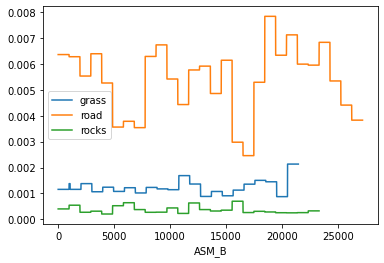

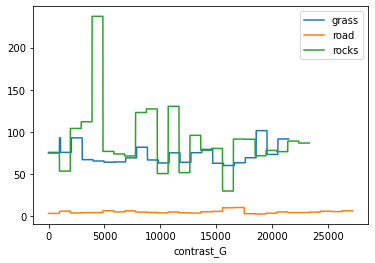

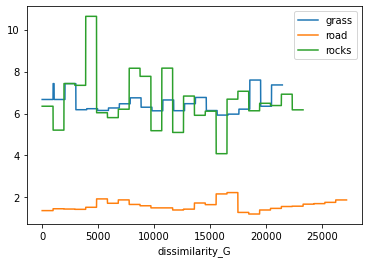

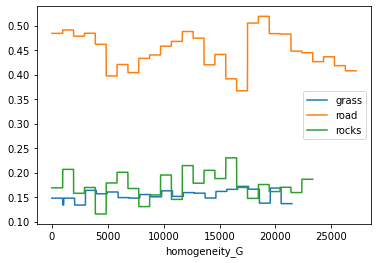

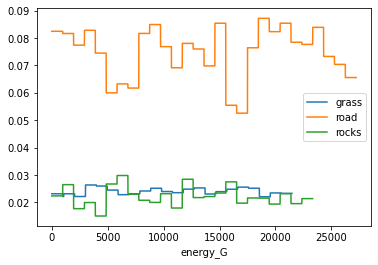

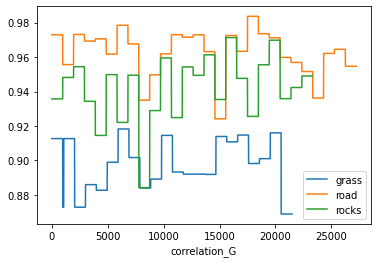

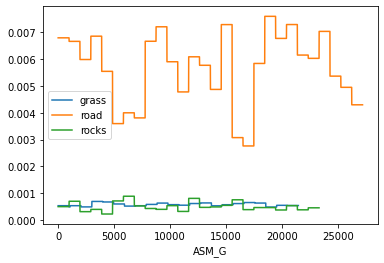

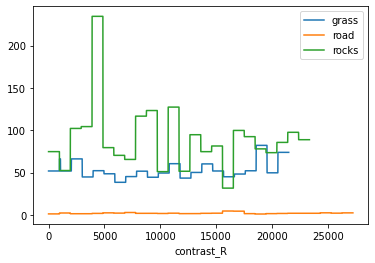

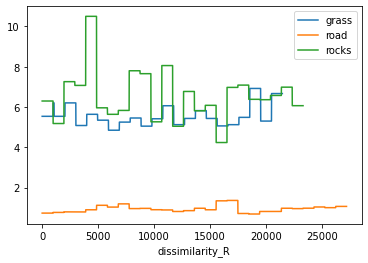

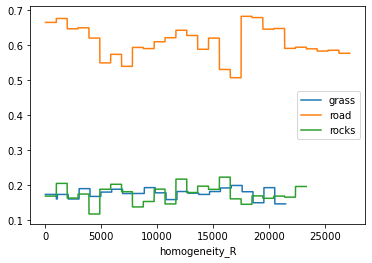

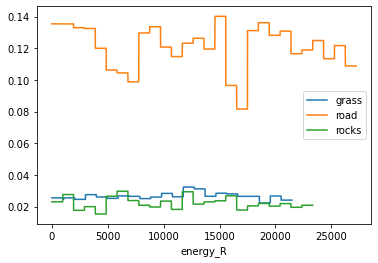

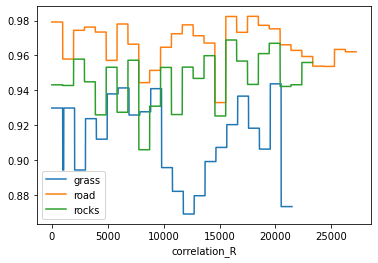

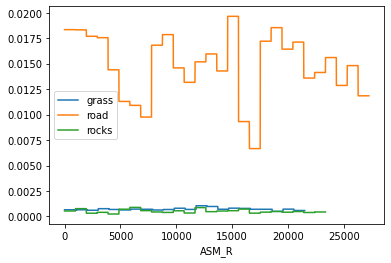

In [18]:
list_features = ["contrast", "dissimilarity", "homogeneity", "energy", "correlation", "ASM"]#feature 종류
rgb = ["B","G","R"]
for n, c in enumerate(rgb):#RGB별로 비교해본다.
    for i in range(len(list_features)):
        for label in kind_of_label:
            plt.plot(glcm_features[labels == label][:,6*n+i], label=label)
        plt.legend()
        plt.xlabel(list_features[i]+"_"+c)
        plt.show()

In [19]:
#model 학습
model = LinearSVC(C=1, random_state=42, max_iter = 100000000)
model.fit(glcm_features, labels)

LinearSVC(C=1, max_iter=100000000, random_state=42)

grass.jpg ['grass']


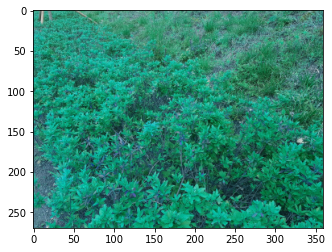

road.jpg ['road']


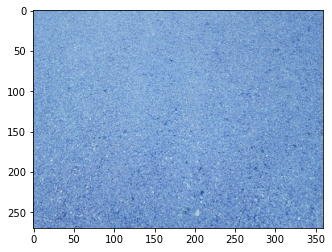

rocks.jpg ['grass']


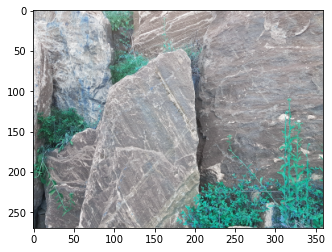

In [20]:
testing_images_path = "./images/testing/"#test이미지가 저장되어 있는 곳

for image_name in os.listdir(testing_images_path):
    
    image = image_read(testing_images_path, image_name)
    feature = []
    for i in range(3):#RGB별로 feature뽑기
        feature += extract_glcm_feature(image[:,:,i])
    
    prediction = model.predict(np.array(feature).reshape([1,-1]))# 분류하기
    
    print(image_name, prediction)
    
    plt.imshow(image)
    plt.show()

In [21]:
# with open("linearSVC2.pickle","wb") as f:
#     pickle.dump(model, f)

In [22]:
import time

(972, 10, 10, 3)
27 36
extracting time :  16.39059329032898


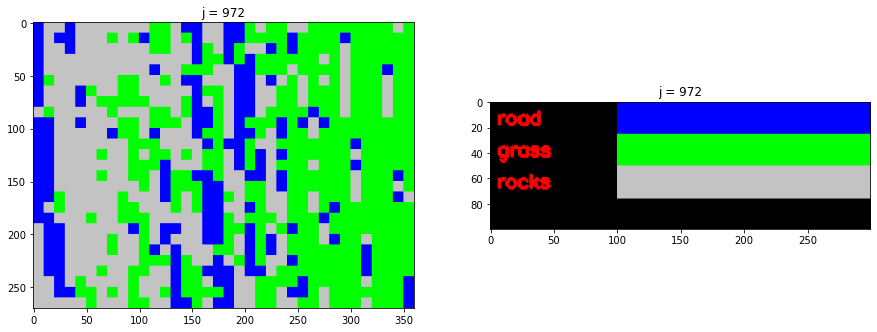

In [23]:
image = image_read("./images/temp/", "road_scene3.jpg")
# cv2.imshow("temp", image)

PATCH_SIZE = 10 #이미지를 블록으로 나눔
height, width, channel = image.shape
# patches = image.reshape(image.shape[0]//PATCH_SIZE, PATCH_SIZE, image.shape[1]//PATCH_SIZE, PATCH_SIZE).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE)
patches = image.reshape(height//PATCH_SIZE, PATCH_SIZE, width//PATCH_SIZE, PATCH_SIZE, channel).swapaxes(1, 2).reshape(-1, PATCH_SIZE, PATCH_SIZE, channel)


mask = np.zeros((height//PATCH_SIZE, width//PATCH_SIZE, channel), np.uint8)
label_color = {
    "road" : np.array([0,0,255]),
    "grass" : np.array([0,255,0]),
    "rocks" : np.array([195,195,195])
}
h = height//PATCH_SIZE
w = width//PATCH_SIZE

print(patches.shape)
print(h, w)

start = time.time()
for i in range(patches.shape[0]):
    feature = extract_glcm_feature_RGB(patches[i])
    prediction = model.predict(np.array(feature).reshape([1, -1]))  # 분류하기
#     print(prediction)
    mask[i%h][i//h] = label_color[prediction[0]]
    cv2.imshow("patch",patches[i])
    cv2.waitKey(2)

end = time.time()
print("extracting time : ", end - start)
mask = cv2.resize(mask, None, fx=PATCH_SIZE, fy=PATCH_SIZE, interpolation=cv2.INTER_AREA)
# cv2.imshow("mask", mask)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
legend_img = get_class_color_legend_img(label_color.keys(), label_color.values())
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=False, sharey=False)

ax[0].imshow(mask)
ax[0].set_title("j = {}".format(i+1))

ax[1].imshow(legend_img)
ax[1].set_title("j = {}".format(i+1))

plt.show()